## Introduction

The notebook documents how I built a predictive model to predict credit default using the data from https://archive-beta.ics.uci.edu/ml/datasets/default+of+credit+card+clients#Descriptive.

The notebook can be divided into four parts
1. Data cleaning and preparation
2. Explorotary Data Analysis (some quick statistical analyses were done using SPSS)
3. Feature Engineering
4. Model Building and Hyperparameter Tuning
5. Feature Selection
6. Model Evaluation and Threshold Moving

### Model Building Process
1. Run XGBoost using original features and without tuning. This model served as the baseline.
2. Run XGBoost without tuning using original and newly generated features. Unfortunately, the newly created featues only improve the model performance slightly.
3. Conduct Bayesian Optimization using Optuna. To deal with the potential issue cause by the imbalanced data, I tested different values for scale_pos_weight to find a best value for **class-weighted XGBoost model**.
4. Since the data is imbalanced. I conducted a series experiments on the effects of different resampling methods.
- experiment 1: SMOTE oversampling on both training and testing datasets
- experiment 2: SMOTE oversampling only on training set
- experiment 3: Randomly undersampling on both training and testing datasets
- experiment 4: SMOTE Oversampling Training & Testing **After Random Undersampling**
- experiment 5: SMOTE Oversampling Training ONLY **After Random Undersampling**
 
 Note: experiment 3-5 were conducted under different sampling_strategy values ranged from 0.5 - 1.
5. After I made a decision on the final model, I filtered out half of features using RFE.

### How to further improve the predictive model?
I have multiple interviews and other take home projects to work on, so I have limited time to work on this interesting project.
If I had more time, I'd try more things to improve the model

1. Generate more features: e.g., create interaction variables among important categorical and numerical variables
2. More finetuned feature selection (e.g., RFE) and Hyperparameter Tuning
3. Try other models such as DNN and DCN.
4. Access to additional features such as demographic variables, credit score, and geo info.
5. Learn from domain knowledge experts
6. Learn from recommendation system. Develop different approaches for new customers and old customers
7. Consider building both online and offline models for default prediction
 

In [1]:
# import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
from collections import Counter
import random

from xgboost import XGBClassifier, plot_importance, DMatrix, cv
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, average_precision_score, precision_recall_curve, auc, roc_curve
from sklearn.metrics import precision_score, recall_score, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn import metrics
from sklearn.feature_selection import RFE
    
import warnings
warnings.filterwarnings('ignore')
import optuna

C:\Users\Feng\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# settings
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns',200) 
pd.set_option('display.max_rows', 150)

## Data cleaning and preparation

Read Data & Do Quality check

In [3]:
df = pd.read_excel('default of credit card clients.xls', index_col=None, header=1) 
# I run a latent class growth analysis on the six months credit usuages
# to identify potential credit usuage patterns that might be predictive for default
df_class = pd.read_csv('classes.csv')

In [4]:
def change_col_names(df):
    """
    Make changes to the column names 
    :param df: df to work on
    """
    
    df.columns = df.columns.str.lower()
    # simple name changes
    df.rename(columns={'pay_0':'pay_1', 'default payment next month':'default'}, inplace=True)
    df.columns = df.columns.str.replace('_amt','')
    df.columns = df.columns.str.replace('pay_','pay_status')

    # make the bill and payment related variables ascending, 
    # which makes the variable names more intuitive and makes it easier to calculate moving average later
    old_name = list(df.columns[6:-1])
    new_name = [x[:-1] + str(10 - int(x[-1])) for x in old_name]
    df_pay = df.iloc[:, 6:-1]
    df_pay.columns = new_name
    df_pay.sort_index(axis=1, inplace=True)
    df = pd.concat([df.iloc[:, :6], df_pay, df.iloc[:, -1]], axis=1)
    
    return df

In [5]:
df = change_col_names(df)
df = pd.concat([df, df_class], axis=1)
df.head()

,id,limit_bal,sex,education,marriage,age,bill4,bill5,bill6,bill7,bill8,bill9,pay4,pay5,pay6,pay7,pay8,pay9,pay_status4,pay_status5,pay_status6,pay_status7,pay_status8,pay_status9,default,class4,class5,class6
0,1,20000,2,2,1,24,0,0,0,689,3102,3913,0,0,0,0,689,0,-2,-2,-1,-1,2,2,1,2,2,2
1,2,120000,2,2,2,26,3261,3455,3272,2682,1725,2682,2000,0,1000,1000,1000,0,2,0,0,0,2,-1,1,2,2,2
2,3,90000,2,2,2,34,15549,14948,14331,13559,14027,29239,5000,1000,1000,1000,1500,1518,0,0,0,0,0,0,0,2,2,2
3,4,50000,2,2,1,37,29547,28959,28314,49291,48233,46990,1000,1069,1100,1200,2019,2000,0,0,0,0,0,0,0,1,3,4
4,5,50000,1,2,1,57,19131,19146,20940,35835,5670,8617,679,689,9000,10000,36681,2000,0,0,0,-1,0,-1,0,4,4,3


In [6]:
assert df['id'].nunique() == df.shape[0]

In [7]:
df.isna().sum()

id             0
limit_bal      0
sex            0
education      0
marriage       0
age            0
bill4          0
bill5          0
bill6          0
bill7          0
bill8          0
bill9          0
pay4           0
pay5           0
pay6           0
pay7           0
pay8           0
pay9           0
pay_status4    0
pay_status5    0
pay_status6    0
pay_status7    0
pay_status8    0
pay_status9    0
default        0
class4         0
class5         0
class6         0
dtype: int64

### Recode categorical variables.
I combined certain categories with variables to reduce the number of categories based on the frequency and default percentage.

 Make the categories more descriptive will make it easy for visulization and one hot encoding.

In [8]:
def get_freq_percent(df, col_names):
    """
    Calculate frequncy and percentage for
    :param df: df to work on
    """
    for col in col_names:
        temp_df1 = df[col].value_counts().to_frame('Counts')
        temp_df2 = (100 * df[col].value_counts() / df.shape[0]).to_frame('%')
        
        print('-------'+ col +'-------')
        print(pd.concat([temp_df1, temp_df2], axis=1))
        print('\n')

In [9]:
# Check the frequency and percent to decide how to merge categories
col_names = ['sex', 'education', 'marriage', 'pay_status9']
get_freq_percent(df, col_names)

-------sex-------
   Counts          %
2   18112  60.373333
1   11888  39.626667


-------education-------
   Counts          %
2   14030  46.766667
1   10585  35.283333
3    4917  16.390000
5     280   0.933333
4     123   0.410000
6      51   0.170000
0      14   0.046667


-------marriage-------
   Counts          %
2   15964  53.213333
1   13659  45.530000
3     323   1.076667
0      54   0.180000


-------pay_status9-------
    Counts          %
 0   14737  49.123333
-1    5686  18.953333
 1    3688  12.293333
-2    2759   9.196667
 2    2667   8.890000
 3     322   1.073333
 4      76   0.253333
 5      26   0.086667
 8      19   0.063333
 6      11   0.036667
 7       9   0.030000




In [10]:
def recode_cat_vars(df):
    """
    Recode categorical variables
    :param df: df to work on
    """
    recode_sex = lambda x: 'male' if x == 1 else 'female'
    recode_edu = lambda x: 'grad_schl' if x == 1 else 'college' if x == 2 else 'high_schl' if x == 3 else 'other'
    recode_marriage = lambda x: 'married' if x == 1 else 'single' if x == 2 else 'other'
    recode_pay_status = lambda x: '0' if x <= 0 else '1' if x == 1 else '2'

    df['sex'] = df['sex'].apply(recode_sex)
    df['education'] = df['education'].apply(recode_edu)
    df['marriage'] = df['marriage'].apply(recode_marriage)

    for i in range(4, 10):
        col_name = 'pay_status' + str(i)
        new_col_name = 'pay_status' + str(i) + '_r'
        df[new_col_name] = df[col_name].apply(recode_pay_status)

In [11]:
recode_cat_vars(df)

### Check frequency of the categorical features

In [12]:
get_freq_percent(df, col_names)

-------sex-------
        Counts          %
female   18112  60.373333
male     11888  39.626667


-------education-------
           Counts          %
college     14030  46.766667
grad_schl   10585  35.283333
high_schl    4917  16.390000
other         468   1.560000


-------marriage-------
         Counts          %
single    15964  53.213333
married   13659  45.530000
other       377   1.256667


-------pay_status9-------
    Counts          %
 0   14737  49.123333
-1    5686  18.953333
 1    3688  12.293333
-2    2759   9.196667
 2    2667   8.890000
 3     322   1.073333
 4      76   0.253333
 5      26   0.086667
 8      19   0.063333
 6      11   0.036667
 7       9   0.030000




### Create pairplot amont the numerica variables in the dataset

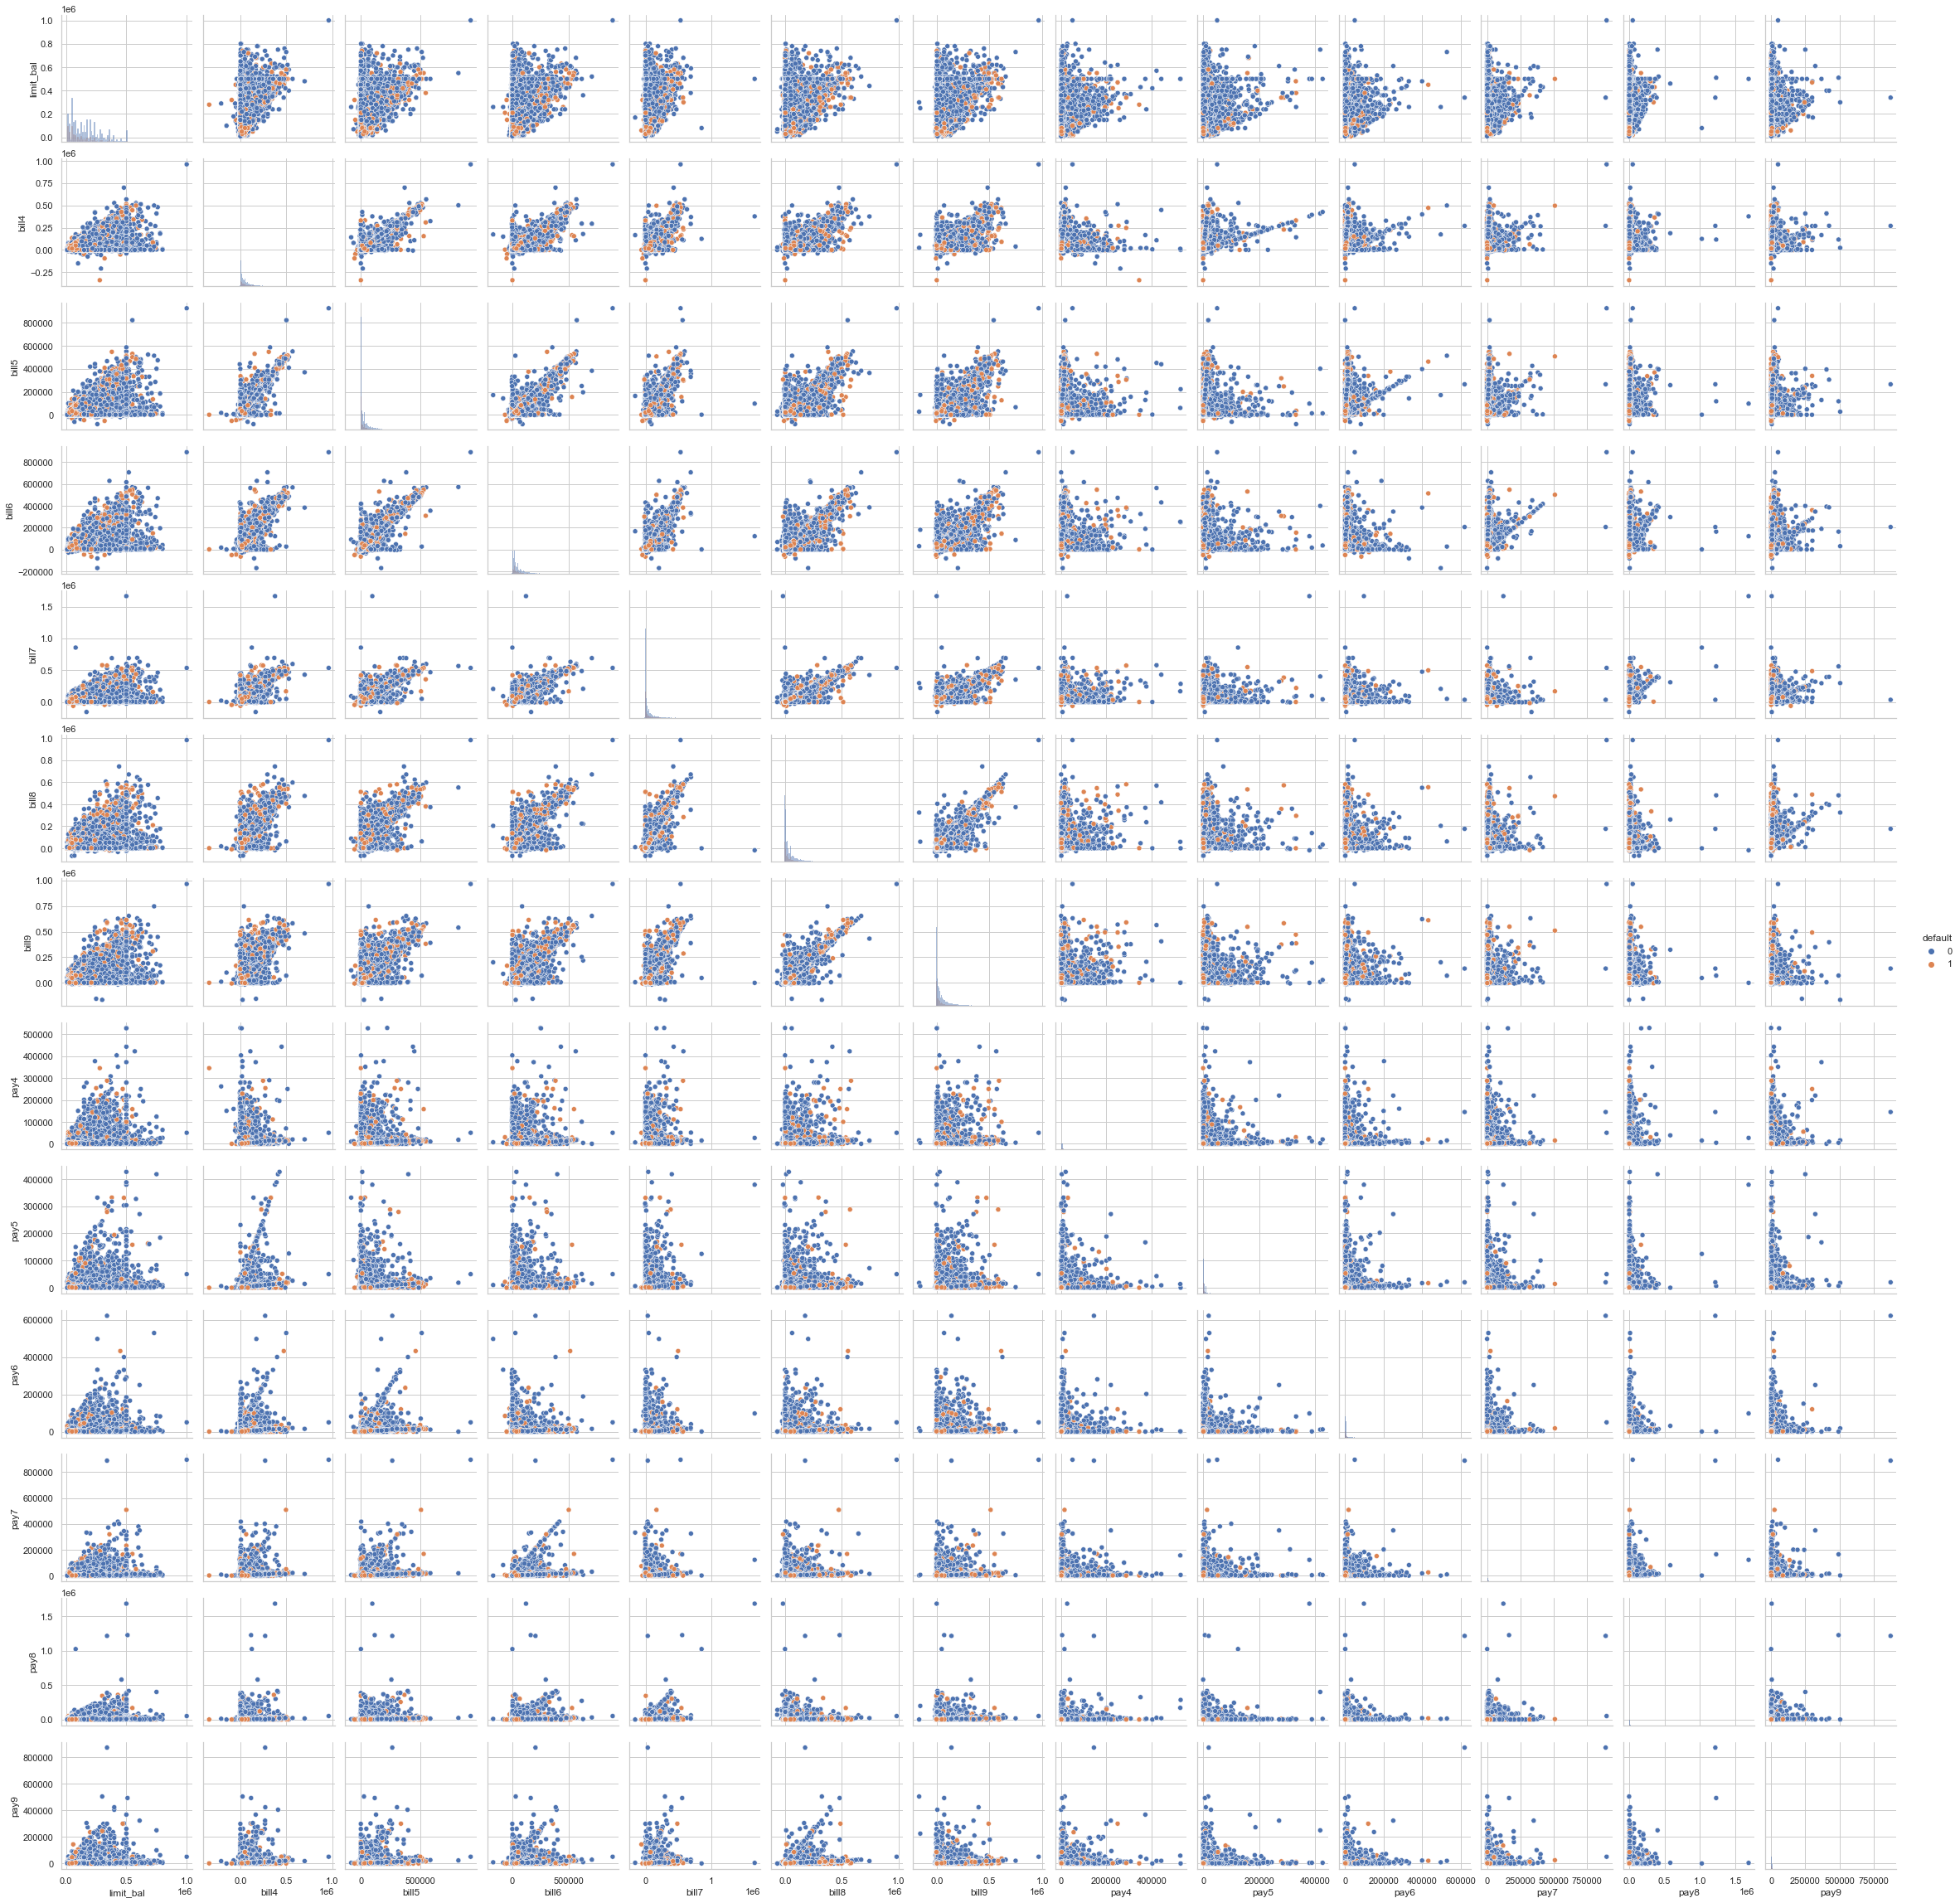

In [33]:
cols4pairplot = ['limit_bal', 'bill4', 'bill5', 'bill6', 'bill7', 'bill8', 'bill9', 
                 'pay4', 'pay5', 'pay6', 'pay7', 'pay8', 'pay9', 'default']
sns.pairplot(df[cols4pairplot], hue='default', diag_kind="hist")

## Feature Engineering

#### Feature Creation
I created the following features.
1. Credit Usage
- Monthly Credit Usage
- Average Credit Usage in the last three months
- Bill Range = max(all six bills) - min(all six bills)
- Bill Range by percent = (max(all six bills) - min(all six bills)) / limit_bal
- Credit Usage pattern identified using Latent Class Growth Analysis (LCGA)

2. Paid Percentage
- Monthly Paid Percentage (*didn't include in the model*)
- Average Paid Percentage in the last three months (*didn't include in the model*)
- pay Range = max(all six pays) - min(all six pays)
- pay Range by percent = (max(all six pays) - min(all six pays)) / limit_bal

3. 3-month moving average (MA) for bills and pays in the last four months
- simply moving average
- exponential moving average
- the difference between bill/pay and the MA

4. Payment status pattern

5. categorical credit limit (created using kmeans)

In [19]:
def get_credit_usage(df):
    """
    calculate monthly credit usuage
    :param df: df to work on
    """
    for i in range(4, 10):
        col_name = 'credit_usage' + str(i)
        bill = 'bill' + str(i)
        df[col_name] = df[bill] / df['limit_bal']
        
        
def get_paid_percentage(df, fillna=0):
    """
    calculate monthly paid percentage
    e.g., df['paid_pct8'] = df['pay9'] / df['bill8']
    :param df: df to work on
    :param fillna: value to fill NaN cased by 0 as denominator
    """

    for i in range(4, 9):
        col_name = 'paid_pct' + str(i)
        bill = 'bill' + str(i)
        pay = 'pay' + str(i+1)
        df[col_name] = (df[pay] / df[bill]).fillna(fillna)
        
        
def get_ma(df, window=3):
    """
    Calculate simple and exponential moving averages in the recent 4 months
    :param df: df to work on
    :param window: size of the moving window.
    """
    # calculate sma and ema for bill related vars
    bill = df.loc[:, 'bill4':'bill9']
    bill_sma = bill.rolling(window, min_periods=3, axis=1).mean().add_suffix('_sma')
    bill_ema = bill.ewm(com=0.5, min_periods=1, axis=1).mean().add_suffix('_ema')

    # calculate sma and ema for pay related vars
    pay = df.loc[:, 'pay4':'pay9']
    pay_sma = pay.rolling(window, min_periods=3, axis=1).mean().add_suffix('_sma')
    pay_ema = pay.ewm(com=0.5, min_periods=1, axis=1).mean().add_suffix('_ema')
    
    return bill_sma.iloc[:, 2:], bill_ema.iloc[:, 2:], pay_sma.iloc[:, 2:], pay_ema.iloc[:, 2:]
    
    
def get_credit_limit_cat(df):
    # categorize credit limit
    bins = [3, 4, 5, 6]
    for bin in bins:
        kbd = KBinsDiscretizer(n_bins=bin, encode='ordinal', strategy='kmeans')
        col_name = 'creditLimit_cat' + str(bin)
        df[col_name] = kbd.fit_transform(df['limit_bal'].values.reshape(-1,1))
        

def get_paystatus_pattern(df):
    """
    Get the top 3 most common pay status patterns
    :param df: df to work on
    """
    df['pattern'] = df['pay_status4_r'] + df['pay_status5_r'] + df['pay_status6_r']\
                  + df['pay_status7_r'] + df['pay_status8_r'] + df['pay_status9_r']
    recode_pattern = lambda x: '1' if x == '000000' \
                          else '2' if x == '222222' \
                          else '3' if x == '000002' \
                          else '4'
    df['pattern_r'] = df['pattern'].apply(recode_pattern)

### Run the function above to generate new features

In [20]:
get_credit_usage(df)
df['avg_credit_usage'] = df.loc[:, 'credit_usage7':'credit_usage9'].mean(axis=1)

get_paid_percentage(df, fillna=0)
df['avg_paid_percentage'] = df.loc[:, 'paid_pct6':'paid_pct8'].mean(axis=1)

get_credit_limit_cat(df)

get_paystatus_pattern(df)

df.head()

,id,limit_bal,sex,education,marriage,age,bill4,bill5,bill6,bill7,bill8,bill9,pay4,pay5,pay6,pay7,pay8,pay9,pay_status4,pay_status5,pay_status6,pay_status7,pay_status8,pay_status9,default,class4,class5,class6,pay_status4_r,pay_status5_r,pay_status6_r,pay_status7_r,pay_status8_r,pay_status9_r,pattern,credit_usage4,credit_usage5,credit_usage6,credit_usage7,credit_usage8,credit_usage9,avg_credit_usage,paid_pct4,paid_pct5,paid_pct6,paid_pct7,paid_pct8,avg_paid_percentage,creditLimit_cat3,creditLimit_cat4,creditLimit_cat5,creditLimit_cat6,pattern_r
0,1,20000,female,college,married,24,0,0,0,689,3102,3913,0,0,0,0,689,0,-2,-2,-1,-1,2,2,1,2,2,2,0,0,0,0,2,2,000022,0.000000,0.000000,0.000000,0.034450,0.155100,0.195650,0.128400,0.000000,0.000000,0.000000,1.000000,0.000000,0.333333,0.0,0.0,0.0,0.0,4
1,2,120000,female,college,single,26,3261,3455,3272,2682,1725,2682,2000,0,1000,1000,1000,0,2,0,0,0,2,-1,1,2,2,2,2,0,0,0,2,0,200020,0.027175,0.028792,0.027267,0.022350,0.014375,0.022350,0.019692,0.000000,0.289436,0.305623,0.372856,0.000000,0.226160,0.0,0.0,0.0,0.0,4
2,3,90000,female,college,single,34,15549,14948,14331,13559,14027,29239,5000,1000,1000,1000,1500,1518,0,0,0,0,0,0,0,2,2,2,0,0,0,0,0,0,000000,0.172767,0.166089,0.159233,0.150656,0.155856,0.324878,0.210463,0.064313,0.066899,0.069779,0.110628,0.108220,0.096209,0.0,0.0,0.0,0.0,1
3,4,50000,female,college,married,37,29547,28959,28314,49291,48233,46990,1000,1069,1100,1200,2019,2000,0,0,0,0,0,0,0,1,3,4,0,0,0,0,0,0,000000,0.590940,0.579180,0.566280,0.985820,0.964660,0.939800,0.963427,0.036180,0.037985,0.042382,0.040961,0.041465,0.041603,0.0,0.0,0.0,0.0,1
4,5,50000,male,college,married,57,19131,19146,20940,35835,5670,8617,679,689,9000,10000,36681,2000,0,0,0,-1,0,-1,0,4,4,3,0,0,0,0,0,0,000000,0.382620,0.382920,0.418800,0.716700,0.113400,0.172340,0.334147,0.036015,0.470072,0.477555,1.023608,0.352734,0.617966,0.0,0.0,0.0,0.0,1


#### Calculate the difference between monthly bill/pay and MA bill/pay

Also calculate the number of months that bill/pay is greater than MA bill/pay

In [22]:
def get_col_names(prefix, start=6, end=10):
    """
    Simple utility function to get column names
    """
    col_name_list = []
    for i in range(start, end):
        col_name_list.append(prefix + str(i))
    return col_name_list
    
bill_sma, bill_ema, pay_sma, pay_ema = get_ma(df)
bill = df.loc[:, 'bill6':'bill9']
bill_sma_diff = pd.DataFrame(bill.values - bill_sma.values, columns=get_col_names('bill_sma_diff'))
bill_ema_diff = pd.DataFrame(bill.values - bill_ema.values, columns=get_col_names('bill_ema_diff'))
bill_sma_diff['sma_diff_counts'] = np.where(bill_sma_diff > 0, 1, 0).sum(axis=1)
bill_ema_diff['ema_diff_counts'] = np.where(bill_ema_diff > 0, 1, 0).sum(axis=1)
bill['bill_range'] = bill.max(axis=1) - bill.min(axis=1)

pay = df.loc[:, 'pay6':'pay9']
pay_sma_diff = pd.DataFrame(pay.values - pay_sma.values, columns=get_col_names('pay_sma_diff'))
pay_ema_diff = pd.DataFrame(pay.values - pay_ema.values, columns=get_col_names('pay_ema_diff'))
pay_sma_diff['sma_diff_counts'] = np.where(pay_sma_diff > 0, 1, 0).sum(axis=1)
pay_ema_diff['ema_diff_counts'] = np.where(pay_ema_diff > 0, 1, 0).sum(axis=1)
pay['pay_range'] = pay.max(axis=1) - pay.min(axis=1)

### One Hot Encoding

In [23]:
def get_ohe_col_name(ohe, category_cols, drop='if_binary'):
    """
    Get col names after one hot encoding
    
    :param ohe: OneHotEncoder transforer
    :param category_cols: categorical columns that need to be encoded
    :param drop: whether encode binary cols
    """
    
    cat_cols_new = []
    col_values = ohe.categories_
    
    for i, j in enumerate(category_cols):
        if (drop == 'if_binary') and (len(col_values[i]) == 2):
            cat_cols_new.append(j)
        else:
            for v in col_values[i]:
                feature_name = j + '_' + str(v)
                cat_cols_new.append(feature_name)
    return cat_cols_new

In [24]:
cat_cols = ['sex', 'education', 'marriage', 'pay_status9_r', 'pattern_r', 'creditLimit_cat4', 'class4']

ohe = OneHotEncoder(drop='if_binary')
df_cat = df[cat_cols]
ohe.fit(df_cat)

df_cat = pd.DataFrame(ohe.transform(df_cat).toarray(), columns=get_ohe_col_name(ohe, cat_cols))

## Preparing training and testing data

In [34]:
num_cols = ['limit_bal', 'bill4', 'bill5', 'bill6', 'bill7', 'bill8', 'bill9', 
            'pay4', 'pay5', 'pay6','pay7', 'pay8', 'pay9', 
            'pay_status4', 'pay_status5', 'pay_status6','pay_status7', 'pay_status8', 'pay_status9', 
            'credit_usage4', 'credit_usage5', 'credit_usage6', 
            'credit_usage7', 'credit_usage8', 'credit_usage9', 'avg_credit_usage']

In [35]:
X = pd.concat([df[num_cols], bill_sma, bill_ema, pay_sma, pay_ema, df_cat], axis=1)

y = df['default']

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)

In [21]:
X

,limit_bal,bill4,bill5,bill6,bill7,bill8,bill9,pay4,pay5,pay6,pay7,pay8,pay9,pay_status4,pay_status5,pay_status6,pay_status7,pay_status8,pay_status9,credit_usage4,credit_usage5,credit_usage6,credit_usage7,credit_usage8,credit_usage9,avg_credit_usage,paid_pct4,paid_pct5,paid_pct6,paid_pct7,paid_pct8,avg_paid_percentage,bill6_sma,bill7_sma,bill8_sma,bill9_sma,bill6_ema,bill7_ema,bill8_ema,bill9_ema,pay6_sma,pay7_sma,pay8_sma,pay9_sma,pay6_ema,pay7_ema,pay8_ema,pay9_ema,sex,education_college,education_grad_schl,education_high_schl,education_other,marriage_married,marriage_other,marriage_single,pay_status9_r_1,pay_status9_r_<=0,pay_status9_r_>=2,pattern_r_1,pattern_r_2,pattern_r_3,pattern_r_4,creditLimit_cat4_0.0,creditLimit_cat4_1.0,creditLimit_cat4_2.0,creditLimit_cat4_3.0,class4_1,class4_2,class4_3,class4_4
0,20000,0,0,0,689,3102,3913,0,0,0,0,689,0,-2,-2,-1,-1,2,2,0.000000,0.000000,0.000000,0.034450,0.155100,0.195650,0.128400,0.000000,0.000000,0.000000,1.000000,0.000000,0.333333,0.000000,229.666667,1263.666667,2568.000000,0.000000,465.075,2230.289256,3353.637363,0.000000,0.000000,229.666667,229.666667,0.000000,0.000,461.231405,153.321429,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,120000,3261,3455,3272,2682,1725,2682,2000,0,1000,1000,1000,0,2,0,0,0,2,-1,0.027175,0.028792,0.027267,0.022350,0.014375,0.022350,0.019692,0.000000,0.289436,0.305623,0.372856,0.000000,0.226160,3329.333333,3136.333333,2559.666667,2363.000000,3313.384615,2887.200,2109.198347,2491.590659,1000.000000,666.666667,1000.000000,666.666667,846.153846,950.000,983.471074,326.923077,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,90000,15549,14948,14331,13559,14027,29239,5000,1000,1000,1000,1500,1518,0,0,0,0,0,0,0.172767,0.166089,0.159233,0.150656,0.155856,0.324878,0.210463,0.064313,0.066899,0.069779,0.110628,0.108220,0.096209,14942.666667,14279.333333,13972.333333,18941.666667,14567.076923,13886.625,13980.595041,24166.837912,2333.333333,1000.000000,1166.666667,1339.333333,1307.692308,1100.000,1367.768595,1468.060440,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,50000,29547,28959,28314,49291,48233,46990,1000,1069,1100,1200,2019,2000,0,0,0,0,0,0,0.590940,0.579180,0.566280,0.985820,0.964660,0.939800,0.963427,0.036180,0.037985,0.042382,0.040961,0.041465,0.041603,28940.000000,35521.333333,41946.000000,48171.333333,28557.692308,42552.675,46355.206612,46778.983516,1056.333333,1123.000000,1439.666667,1739.666667,1085.153846,1162.675,1735.917355,1912.214286,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,50000,19131,19146,20940,35835,5670,8617,679,689,9000,10000,36681,2000,0,0,0,-1,0,-1,0.382620,0.382920,0.418800,0.716700,0.113400,0.172340,0.334147,0.036015,0.470072,0.477555,1.023608,0.352734,0.617966,19739.000000,25307.000000,20815.000000,16707.333333,20386.846154,30814.350,13982.181818,10400.480769,3456.000000,6563.000000,18560.333333,16227.000000,6442.000000,8843.650,27478.570248,10469.524725,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,15980,31237,88004,208365,192815,188948,1000,5000,3047,5003,20000,8500,0,0,0,0,0,0,0.072636,0.141986,0.400018,0.947114,0.876432,0.858855,0.894133,0.312891,0.097545,0.056850,0.095985,0.044084,0.065640,45073.666667,109202.000000,163061.333333,196709.333333,69363.615385,163189.550,183021.462810,186977.914835,3015.666667,4350.000000,9350.000000,11167.666667,3340.230769,4462.600,14863.669421,10615.395604,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
29996,150000,0,5190,89

## Model Building

In [37]:
def get_metrics(model, X_test, y_test):
    """
    Pass model and testing set to get metrics
    
    :param model: a sklearn model or XGBoost model
    :param X: data set of features   
    :param y: data set of label
    """
    # Make predictions
    y_pred = model.predict(X_test)
    try:
        probab = xgb.decision_function(X_test)
    except:
        probab = xgb.predict_proba(X_test)[:,1]

    target_names = ['Not Default', 'Default']
    report = classification_report(y_test, y_pred, digits=3, target_names=target_names)
    print(report)
    
    fp_r, tp_r, thresholds = roc_curve(y_test, probab)
    auc = metrics.auc(fp_r, tp_r)
    print(f'AUC = {auc}\n')
    
    return fp_r, tp_r, thresholds, auc, y_pred, probab

### Run XGBoost using original features and without tuning

In [60]:
X_train_base = pd.concat([X_train.loc[:, 'limit_bal':'pay_status9'], X_train.loc[:, 'sex':'marriage_single']], axis=1)
X_test_base = pd.concat([X_test.loc[:, 'limit_bal':'pay_status9'], X_test.loc[:, 'sex':'marriage_single']], axis=1)

xgb = XGBClassifier(random_state = 42, n_jobs = -1)
xgb.fit(X_train_base, y_train)

fp_r, tp_r, thresholds, auc, y_pred, probab = get_metrics(xgb, X_test_base, y_test)

              precision    recall  f1-score   support

 Not Default      0.840     0.943     0.889      7710
     Default      0.648     0.367     0.468      2190

    accuracy                          0.816      9900
   macro avg      0.744     0.655     0.678      9900
weighted avg      0.797     0.816     0.796      9900

AUC = 0.7698022197347927



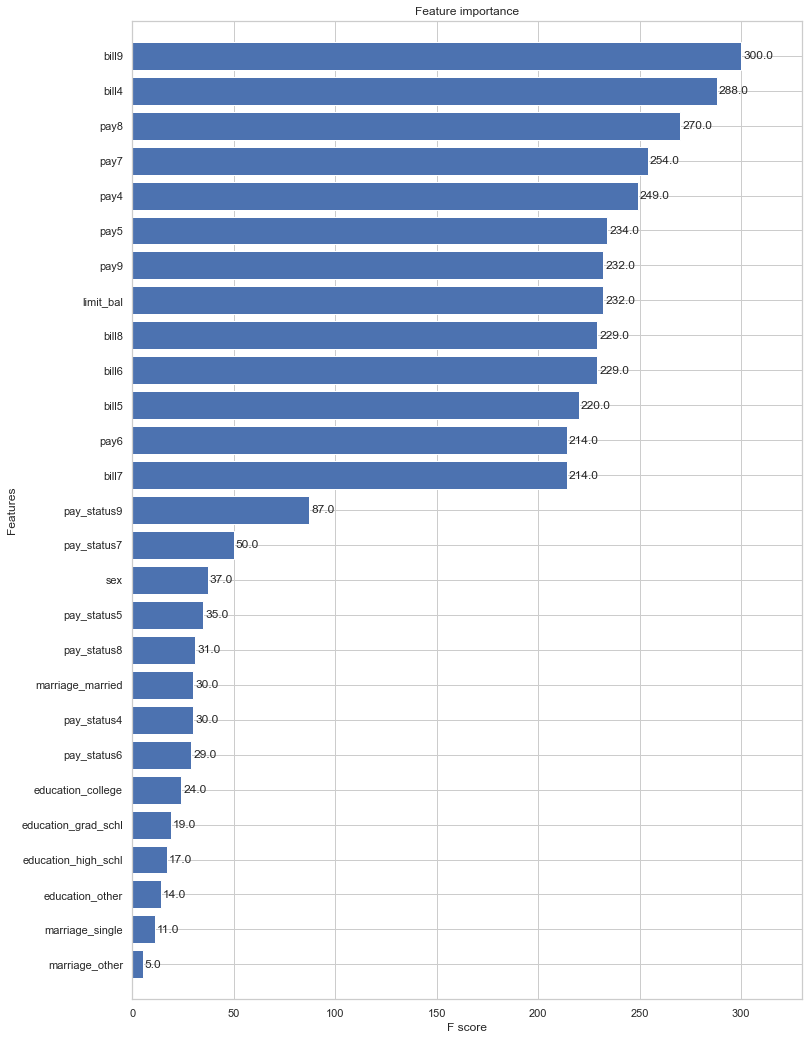

In [61]:
fig, ax = plt.subplots(figsize=(12,18))
plot_importance(xgb, max_num_features=50, height=0.8, ax=ax)
plt.show()

### Run XGBoost using original and newly generated features and without tuning

In [62]:
xgb = XGBClassifier(random_state = 42, n_jobs = -1)
xgb.fit(X_train, y_train)

fp_r, tp_r, thresholds, auc, y_pred, probab = get_metrics(xgb, X_test, y_test)

              precision    recall  f1-score   support

 Not Default      0.840     0.940     0.887      7710
     Default      0.637     0.369     0.467      2190

    accuracy                          0.814      9900
   macro avg      0.739     0.655     0.677      9900
weighted avg      0.795     0.814     0.794      9900

AUC = 0.7720531658464072



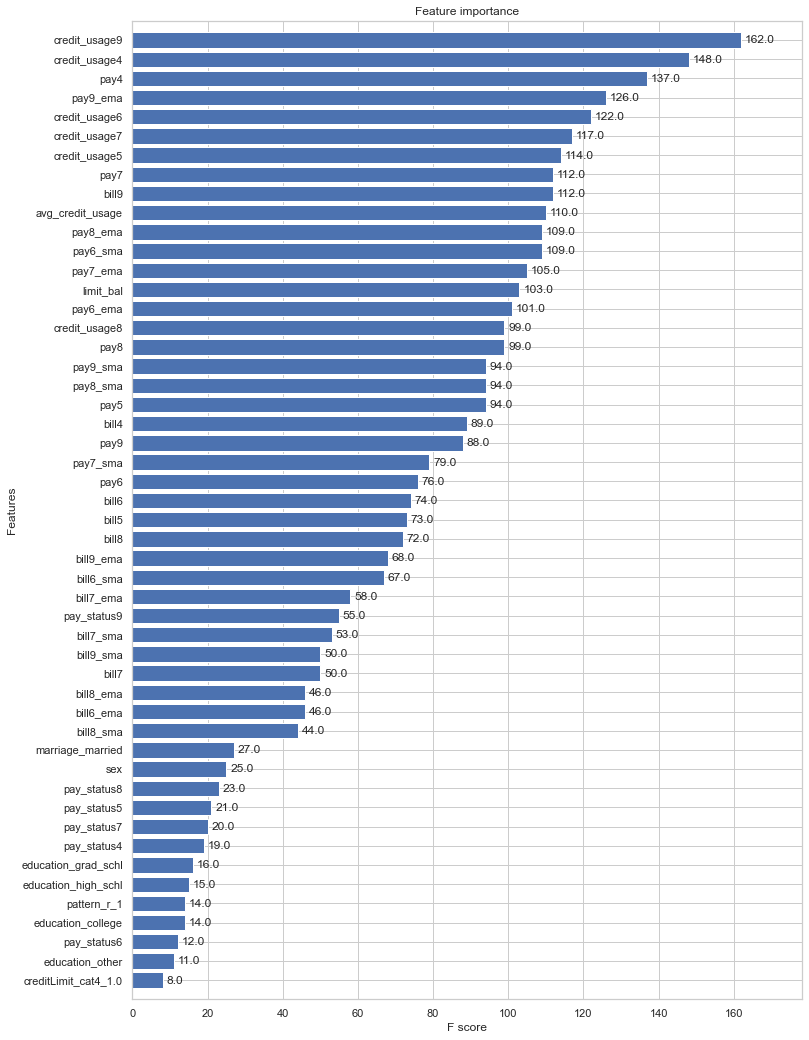

In [63]:
fig, ax = plt.subplots(figsize=(12,18))
plot_importance(xgb, max_num_features=50, height=0.8, ax=ax)
plt.show()

### Bayesian Optimization using Optuna

In [39]:
def objective(trial):

    dtrain = DMatrix(X_train, label=y_train)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": "gbtree", 
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "eta": trial.suggest_float("eta", 1e-8, 1.0, log=True),
        'n_estimators':trial.suggest_int('n_estimators', 100, 400, step=100),
        'scale_pos_weight':trial.suggest_int('scale_pos_weight', 5, 10, step=1),
    }

    param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-auc")
    history = cv(param, dtrain, num_boost_round=100, callbacks=[pruning_callback])

    mean_auc = history["test-auc-mean"].values[-1]
    return mean_auc


pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
study = optuna.create_study(pruner=pruner, direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-09-29 10:29:09,749] A new study created in memory with name: no-name-023549b2-316f-4a2c-8360-6637d0bd706f
[I 2022-09-29 10:29:29,825] Trial 0 finished with value: 0.7695976666666665 and parameters: {'lambda': 2.305154741668557e-08, 'alpha': 3.894922638583384e-07, 'max_depth': 6, 'eta': 0.007169534037107489, 'n_estimators': 400, 'scale_pos_weight': 6, 'gamma': 6.750293441864347e-06, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.7695976666666665.
[I 2022-09-29 10:29:49,674] Trial 1 finished with value: 0.767699 and parameters: {'lambda': 0.00012389581101037288, 'alpha': 5.125096551549229e-08, 'max_depth': 6, 'eta': 0.0030536262591888247, 'n_estimators': 400, 'scale_pos_weight': 8, 'gamma': 0.1857239623797173, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.7695976666666665.
[I 2022-09-29 10:29:56,724] Trial 2 finished with value: 0.7483273333333335 and parameters: {'lambda': 0.15522943302608752, 'alpha': 0.005914313572318507, 'max_depth': 2, 'eta': 1.46341

[I 2022-09-29 10:33:26,196] Trial 47 pruned. Trial was pruned at iteration 5.
[I 2022-09-29 10:33:27,386] Trial 48 pruned. Trial was pruned at iteration 5.
[I 2022-09-29 10:33:28,764] Trial 49 pruned. Trial was pruned at iteration 5.
[I 2022-09-29 10:33:29,728] Trial 50 pruned. Trial was pruned at iteration 5.
[I 2022-09-29 10:33:30,902] Trial 51 pruned. Trial was pruned at iteration 5.
[I 2022-09-29 10:33:43,590] Trial 52 finished with value: 0.7714136666666667 and parameters: {'lambda': 0.004085605771686366, 'alpha': 0.14348271289366854, 'max_depth': 4, 'eta': 0.1528449900472774, 'n_estimators': 200, 'scale_pos_weight': 7, 'gamma': 6.438924863114943e-07, 'grow_policy': 'depthwise'}. Best is trial 15 with value: 0.7761840000000001.
[I 2022-09-29 10:33:44,954] Trial 53 pruned. Trial was pruned at iteration 5.
[I 2022-09-29 10:33:46,021] Trial 54 pruned. Trial was pruned at iteration 5.
[I 2022-09-29 10:33:47,377] Trial 55 pruned. Trial was pruned at iteration 5.
[I 2022-09-29 10:33:48,

Number of finished trials: 100
Best trial:
  Value: 0.7762929999999999
  Params: 
    lambda: 3.702727579429695e-07
    alpha: 0.2992423614441431
    max_depth: 4
    eta: 0.07568980908037011
    n_estimators: 300
    scale_pos_weight: 6
    gamma: 4.930821038093822e-07
    grow_policy: depthwise


### Train a XGBoost Model using the params obtained from the Hyperparameter tuning

In [41]:
model_params = {'lambda': 3.702727579429695e-07, 
                'alpha': 0.2992423614441431, 
                'max_depth': 4, 
                'eta': 0.07568980908037011, 
                'n_estimators': 300, 
                'scale_pos_weight': 6, 
                'gamma': 4.930821038093822e-07, 
                'grow_policy': 'depthwise'}

xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
xgb.set_params(**model_params)
xgb.fit(X_train, y_train)
get_metrics(xgb, X_test, y_test)

              precision    recall  f1-score   support

 Not Default      0.903     0.625     0.739      7710
     Default      0.367     0.764     0.496      2190

    accuracy                          0.656      9900
   macro avg      0.635     0.695     0.617      9900
weighted avg      0.785     0.656     0.685      9900

AUC = 0.7796407737090536



(array([0.        , 0.        , 0.        , ..., 0.99935149, 0.99935149,
        1.        ]),
 array([0.00000000e+00, 4.56621005e-04, 2.28310502e-03, ...,
        9.99543379e-01, 1.00000000e+00, 1.00000000e+00]),
 array([1.978437  , 0.9784369 , 0.9707309 , ..., 0.0168308 , 0.0166652 ,
        0.01009325], dtype=float32),
 0.7796407737090536,
 array([0, 0, 0, ..., 1, 1, 0]),
 array([0.47197977, 0.35697272, 0.34006873, ..., 0.50523376, 0.5771252 ,
        0.10166515], dtype=float32))

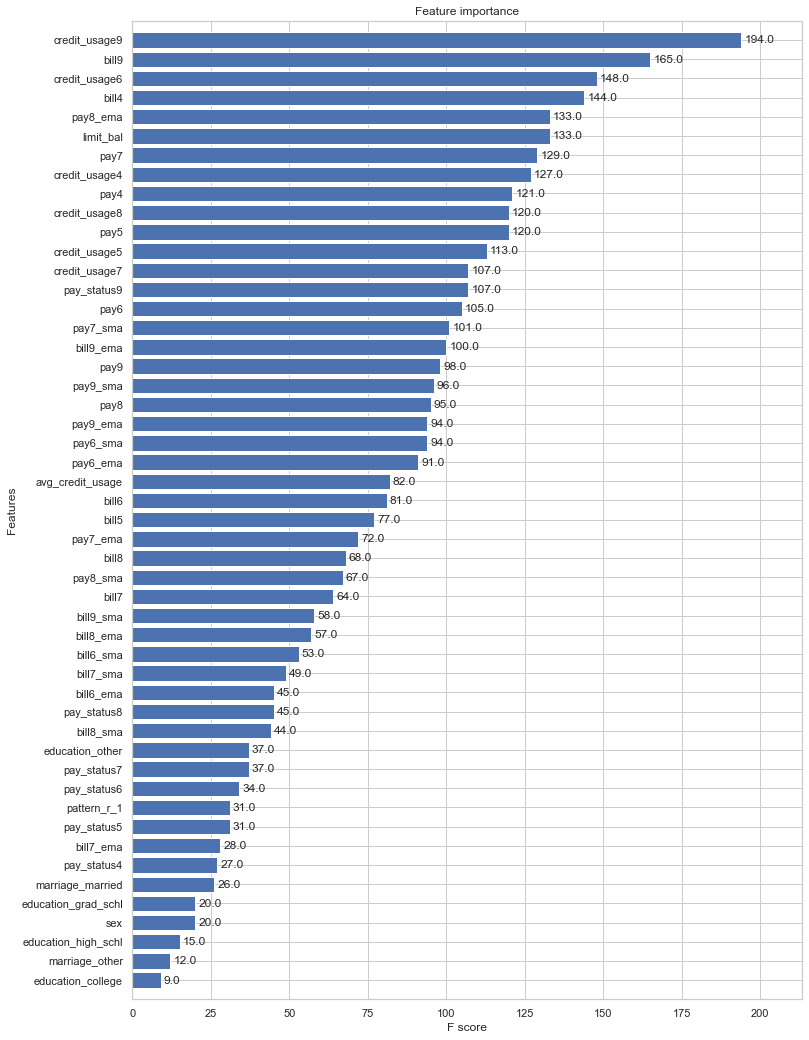

In [42]:
fig, ax = plt.subplots(figsize=(12,18))
plot_importance(xgb, max_num_features=50, height=0.8, ax=ax)
plt.show()

### Experiment with the Impact of Threshold on the Confusion Matrix (Precision-Recall Trade-off)

Typically for a binary classification model, the default threshold is set at 0.5 but it can be changed depending on the specific situation.

  When we are making changes to the threshold, we are changing the criteria to assign cases to different classes. Accordingly, both the precision and recall will change. This is known as **The Precision-Recall Trade-Off**.
  
  In terms of the default detection context, typically we prefer a higher recall, because the cost of an actual fraud usually more costly. 

              precision    recall  f1-score   support

 Not Default      0.903     0.625     0.739      7710
     Default      0.367     0.764     0.496      2190

    accuracy                          0.656      9900
   macro avg      0.635     0.695     0.617      9900
weighted avg      0.785     0.656     0.685      9900

AUC = 0.7796407737090536

Threshold value is: 0.67


Text(0.5, 0.98, 'Impact of threshold adjustment on the error matrix')

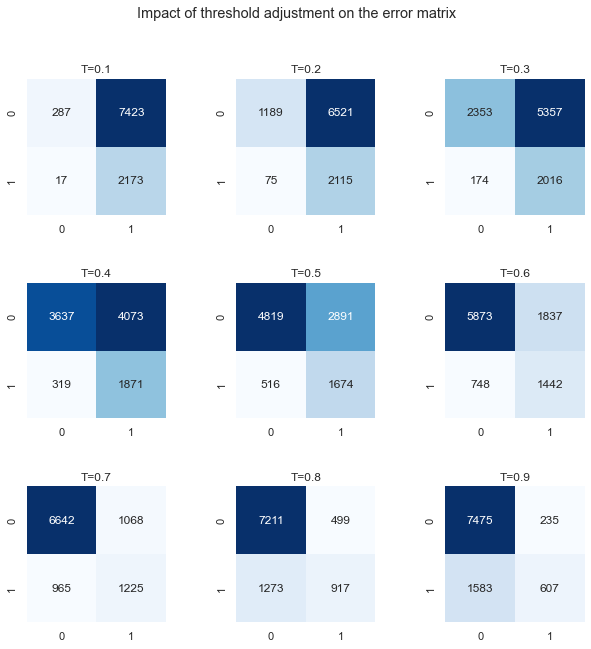

In [45]:
fp_r, tp_r, thresholds, auc, y_pred, probab = get_metrics(xgb, X_test, y_test)
t_opt_idx = np.argmax(tp_r - fp_r)
t_opt = thresholds[t_opt_idx]

print("Threshold value is: %.2f" % t_opt)

fig, axes = plt.subplots(3,3, figsize=(10,10))

for t, ax in enumerate(axes.flat):
    thresholds = (t+1)/10

    y_pred_int = (probab > thresholds).astype(int)
    c_matrix = confusion_matrix(y_test, y_pred_int)
    sns.heatmap(c_matrix, annot=True, cmap="Blues", fmt="d", ax=ax, cbar=False)
    ax.title.set_text("T=%.1f" % thresholds)

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Impact of threshold adjustment on the error matrix")

### Run Resampling Experiments

In [46]:
def resampling_experiments(model, sampling_strategy, X, y):
    """
    Run 5 different resampling experiment
    Check the related experiments below for details
    
    :param model: a sklearn model or XGBoost model
    :param sampling_strategy: a list of ratios used in random undersampling
    :param X: data set of features   
    :param y: data set of label
    """
    seed = 7
    test_size = 0.33
    smote = SMOTE(random_state=42)
    # experiment 1: SMOTE oversampling on both training and testing datasets
    print('experiment 1: SMOTE Oversampling on both training and testing datasets')
    X_smote, y_smote = smote.fit_sample(X, y)
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_smote, y_smote, 
                                                                test_size = 0.25, random_state = 42)
    
    model.fit(X_train_s, y_train_s)
    get_metrics(model, X_test_s, y_test_s)
    
    # experiment 2: SMOTE oversampling only on training set
    print('experiment 2: SMOTE oversampling only on training set')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
    X_smote, y_smote = smote.fit_sample(X_train, y_train)
    
    model.fit(X_smote, y_smote)
    get_metrics(model, X_test, y_test)
    
    for ss in sampling_strategy:
        # Initiate the sampler
        under = RandomUnderSampler(sampling_strategy=ss)
        # fit and apply the transform
        X_u, y_u = under.fit_resample(X, y)

        # summarize class distribution
        print(f'-----Sampling Strategy = {ss}-----\n')
        print(Counter(y_u))

        X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_u, y_u, test_size=test_size, 
                                                                    random_state=seed, stratify=y_u)
        # experiment 3: randomly undersampling on both training and testing datasets
        print('experiment 3: Random Undersampling')
        model.fit(X_train_u, y_train_u)
        get_metrics(model, X_test_u, y_test_u)

        # experiment 4: SMOTE Oversampling Training & Testing After Random Undersampling
        print('experiment 4: SMOTE Oversampling Training & Testing After Random Undersampling')
        X_smote, y_smote = smote.fit_sample(X_u, y_u)
        X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_smote, y_smote, test_size = 0.25, random_state = 42)

        model.fit(X_train_s, y_train_s)
        get_metrics(model, X_test_s, y_test_s)

        # experiment 5: SMOTE Oversampling Training ONLY After Random Undersampling
        print('experiment 5: SMOTE Oversampling Training ONLY After Random Undersampling')
        X_smote, y_smote = smote.fit_sample(X_train_u, y_train_u)

        model.fit(X_smote, y_smote)
        get_metrics(model, X_test_u, y_test_u)

In [48]:
# Run reampling experiment using XGBoost Classifier

model_params = {'lambda': 3.702727579429695e-07, 
                'alpha': 0.2992423614441431, 
                'max_depth': 4, 
                'eta': 0.07568980908037011, 
                'n_estimators': 300, 
#                 'scale_pos_weight': 6, 
                'gamma': 4.930821038093822e-07, 
                'grow_policy': 'depthwise'}

# Initiate XGBoost Classifier
xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
xgb.set_params(**model_params)

# Specify sampling strategy
sampling_strategy = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

resampling_experiments(xgb, sampling_strategy, X, y)

experiment 1: SMOTE Oversampling on both training and testing datasets
              precision    recall  f1-score   support

 Not Default      0.825     0.943     0.880      5819
     Default      0.934     0.802     0.863      5863

    accuracy                          0.872     11682
   macro avg      0.880     0.872     0.872     11682
weighted avg      0.880     0.872     0.872     11682

AUC = 0.9317055027176202

experiment 2: SMOTE oversampling only on training set
              precision    recall  f1-score   support

 Not Default      0.844     0.938     0.889      5873
     Default      0.625     0.376     0.469      1627

    accuracy                          0.816      7500
   macro avg      0.735     0.657     0.679      7500
weighted avg      0.797     0.816     0.798      7500

AUC = 0.7726912958167714

-----Sampling Strategy = 0.5-----

Counter({0: 13272, 1: 6636})
experiment 3: Random Undersampling
              precision    recall  f1-score   support

 Not Default   

              precision    recall  f1-score   support

 Not Default      0.685     0.760     0.721      2190
     Default      0.730     0.651     0.688      2190

    accuracy                          0.705      4380
   macro avg      0.708     0.705     0.704      4380
weighted avg      0.708     0.705     0.704      4380

AUC = 0.7718298200621339



In [49]:
# Run reampling experiment using Random Forest Classifier

# Initiate Random Forest Classifier
rfc = RandomForestClassifier(n_jobs=-1, random_state = 42,
                             n_estimators=500, 
                             max_features='auto',
                             min_samples_leaf=2,
                             criterion = 'entropy')
resampling_experiments(rfc, sampling_strategy, X, y)

experiment 1: SMOTE Oversampling on both training and testing datasets
              precision    recall  f1-score   support

 Not Default      0.839     0.932     0.883      5819
     Default      0.924     0.823     0.871      5863

    accuracy                          0.877     11682
   macro avg      0.882     0.877     0.877     11682
weighted avg      0.882     0.877     0.877     11682

AUC = 0.8027308513164352

experiment 2: SMOTE oversampling only on training set
              precision    recall  f1-score   support

 Not Default      0.848     0.932     0.888      5873
     Default      0.617     0.396     0.482      1627

    accuracy                          0.816      7500
   macro avg      0.733     0.664     0.685      7500
weighted avg      0.798     0.816     0.800      7500

AUC = 0.8379256545873519

-----Sampling Strategy = 0.5-----

Counter({0: 13272, 1: 6636})
experiment 3: Random Undersampling
              precision    recall  f1-score   support

 Not Default   

              precision    recall  f1-score   support

 Not Default      0.671     0.751     0.709      2190
     Default      0.717     0.632     0.672      2190

    accuracy                          0.692      4380
   macro avg      0.694     0.692     0.690      4380
weighted avg      0.694     0.692     0.690      4380

AUC = 0.778436333687788



In [54]:
# Initiate the sampler
ss = 1
seed = 7
test_size = 0.33

under = RandomUnderSampler(sampling_strategy=ss)
# fit and apply the transform
X_u, y_u = under.fit_resample(X, y)

print(f'-----Sampling Strategy = {ss}-----\n')
print(Counter(y_u))

X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_u, y_u, test_size=test_size, 
                                                            random_state=seed, stratify=y_u)

xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
xgb.set_params(**model_params)
xgb.fit(X_train_u, y_train_u)
get_metrics(xgb, X_test_u, y_test_u)

-----Sampling Strategy = 1-----

Counter({0: 6636, 1: 6636})
              precision    recall  f1-score   support

 Not Default      0.676     0.759     0.715      2190
     Default      0.726     0.637     0.678      2190

    accuracy                          0.698      4380
   macro avg      0.701     0.698     0.697      4380
weighted avg      0.701     0.698     0.697      4380

AUC = 0.7689840703905257



(array([0.        , 0.        , 0.        , ..., 0.99771689, 0.99771689,
        1.        ]),
 array([0.00000000e+00, 4.56621005e-04, 9.13242009e-04, ...,
        9.99086758e-01, 1.00000000e+00, 1.00000000e+00]),
 array([1.9870473 , 0.9870473 , 0.9834983 , ..., 0.04479725, 0.04389169,
        0.03112113], dtype=float32),
 0.7689840703905257,
 array([1, 0, 0, ..., 0, 0, 0]),
 array([0.5945789 , 0.16556181, 0.35072973, ..., 0.18100768, 0.46280545,
        0.40430734], dtype=float32))

### Recursive Feature Elimination (RFE)

RFE is an efficient approach for **selecting a subset of the most relevant features (columns)** from a training dataset for feature selection.

 Fewer features can allow machine learning algorithms to run more efficiently (less space or time complexity) and be more effective. Some machine learning algorithms can be misled by irrelevant input features, resulting in worse predictive performance.

 In the experiment below, I chose to use the default RFE() feature selector, which means I would like to **keep half of the features** and I want it **exclude one feature at a time**.

In [55]:
xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False, random_state = 42,)
xgb.set_params(**model_params)

rfe = RFE(xgb)
rfe = rfe.fit(X_u, y_u)

In [56]:
df_rfe = pd.DataFrame()
for i,j,k in zip(X_train.columns,rfe.support_,rfe.ranking_):
  df_rfe = df_rfe.append({"Feature" : i, "Selected" : j, "Rank" : k},ignore_index=True)
df_rfe.sort_values('Rank')

,Feature,Selected,Rank
0,limit_bal,True,1
23,credit_usage8,True,1
24,credit_usage9,True,1
25,avg_credit_usage,True,1
27,bill7_sma,True,1
28,bill8_sma,True,1
29,bill9_sma,True,1
33,bill9_ema,True,1
22,credit_usage7,True,1
36,pay8_sma,True,1


In [57]:
selected_features = X_train_u.columns[rfe.support_]
X_train_u_new = X_train_u[selected_features]
X_test_u_new = X_test_u[selected_features]

              precision    recall  f1-score   support

   Not Fraud      0.683     0.758     0.719      2190
       Fraud      0.728     0.648     0.686      2190

    accuracy                          0.703      4380
   macro avg      0.706     0.703     0.702      4380
weighted avg      0.706     0.703     0.702      4380



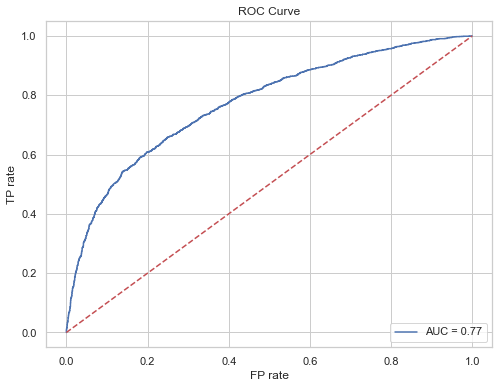

In [65]:
model = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
model.set_params(**model_params)
model.fit(X_train_u_new, y_train_u)

y_pred_u = model.predict(X_test_u_new)

target_names = ['Not Fraud', 'Fraud']
print(classification_report(y_test_u, y_pred_u, digits=3, target_names=target_names))
    
proba = model.predict_proba(X_test_u_new)[:,1]
fp_r, tp_r, thresholds = roc_curve(y_test_u, proba)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

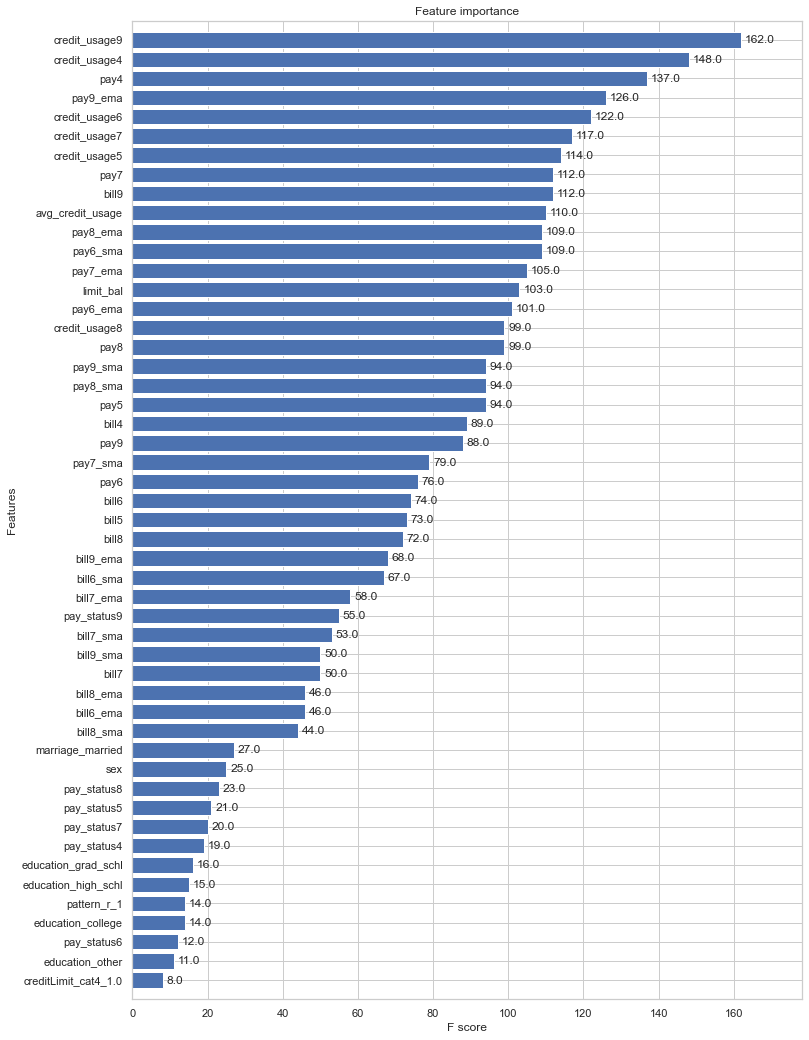

In [66]:
fig, ax = plt.subplots(figsize=(12,18))
plot_importance(xgb, max_num_features=50, height=0.8, ax=ax)
plt.show()